In [1]:
#Please rename this to the data file provided
data_and_output_dir='/Users/ansonkong/Downloads/Data for nyu work/'

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=a

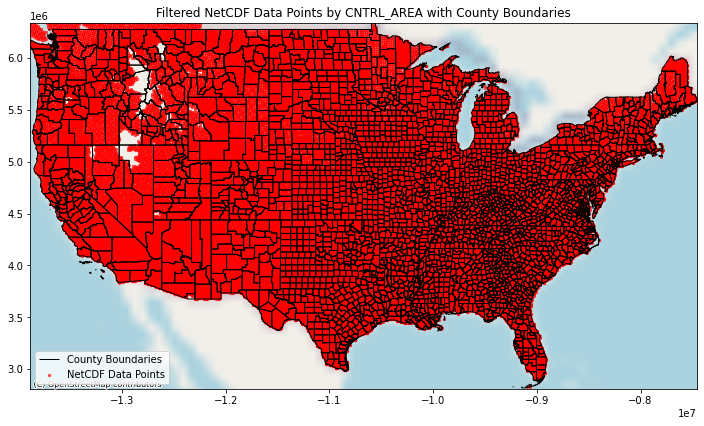

/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_64769/2901128272.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counties_with_majority_cntrl_area['CNTRL_AREA'].fillna('No Control Area', inplace=True)


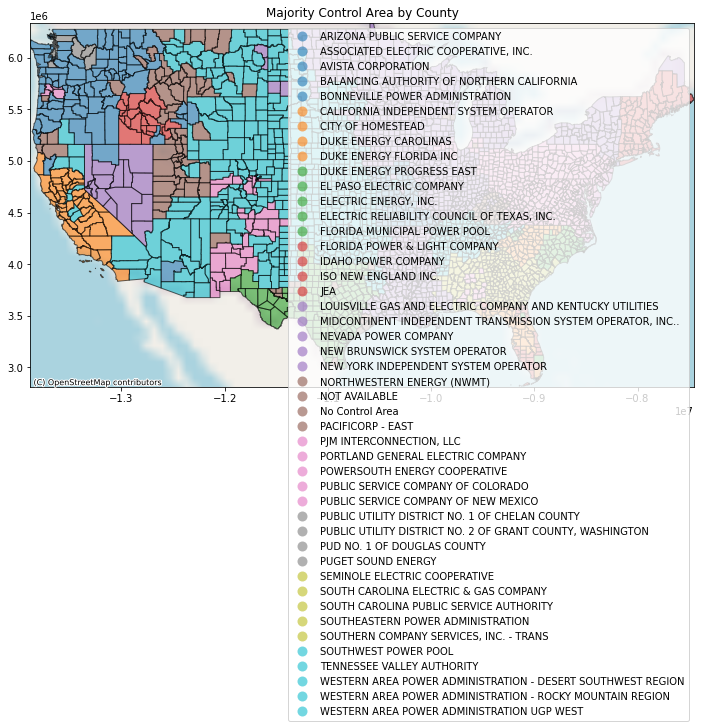

Mapping saved
Filtered mapping saved


In [2]:
import geopandas as gpd
import netCDF4 as nc
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Load shapefiles
shapefile_path = data_and_output_dir+'input/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
new_county_shapefile_path = data_and_output_dir+'input/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'  # New county shapefile
nc_file_path = data_and_output_dir+'input/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load and prepare geographic data
ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=4326)
new_counties = gpd.read_file(new_county_shapefile_path).to_crs(epsg=4326)  # Load new county shapefile

# Load NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Extract data points from NetCDF
time_step = 0
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Perform spatial join to filter points based on 'CNTRL_AREA'
gdf_points_filtered = gpd.sjoin(gdf_points, ba_subregions, how='inner', op='intersects')

# Drop 'index_left' and 'index_right' if they exist before performing another spatial join
gdf_points_filtered = gdf_points_filtered.drop(columns=['index_left', 'index_right'], errors='ignore')

# Perform spatial join to associate points with new counties
gdf_points_with_county = gpd.sjoin(gdf_points_filtered, new_counties, how='left', op='intersects')

# Use 'GEOID' as FIPS for further processing
gdf_points_with_county['FIPS'] = gdf_points_with_county['GEOID']

# Continue with your analysis using gdf_points_with_new_county...

gdf_points_with_county = gdf_points_with_county.to_crs(epsg=3857)
counties = new_counties.to_crs(epsg=3857)
counties['FIPS'] = counties['GEOID'].astype(str).str.zfill(5)
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot counties
counties.boundary.plot(ax=ax, color='black', linewidth=1, label='County Boundaries')

# Plot filtered NetCDF data points
gdf_points_with_county.plot(ax=ax, color='red', markersize=5, alpha=0.6, label='NetCDF Data Points')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Filtered NetCDF Data Points by CNTRL_AREA with County Boundaries')
plt.legend()
plt.tight_layout()
ax.set_xlim([-13884029, -7453304])  # These limits might need adjustment to better fit your specific shapefile
ax.set_ylim([2810491, 6338219])
plt.show()

# Cleanup
ds.close()

# Group by 'FIPS' code and determine the most common 'CNTRL_AREA' within each county
majority_cntrl_area_by_county = gdf_points_with_county.groupby('FIPS')['CNTRL_AREA'].agg(lambda x: x.mode()[0] if not x.empty else np.nan).reset_index()

# Merge this information back with the counties GeoDataFrame to assign each county its majority control area
counties_with_majority_cntrl_area = counties.merge(majority_cntrl_area_by_county, on='FIPS', how='left')

# Check if any county does not have a control area assigned and fill with a placeholder if necessary
counties_with_majority_cntrl_area['CNTRL_AREA'].fillna('No Control Area', inplace=True)

# Plotting to visualize the results
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each county colored by its majority control area
counties_with_majority_cntrl_area.plot(ax=ax, column='CNTRL_AREA',  alpha=0.6, edgecolor='black',legend=True)

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=counties_with_majority_cntrl_area.crs.to_string())

# Set title and adjust plot
ax.set_title('Majority Control Area by County')
plt.tight_layout()
ax.set_xlim([-13884029, -7453304])  # These limits might need adjustment to better fit your specific shapefile
ax.set_ylim([2810491, 6338219])
plt.show()
# Rename 'CNTRL_AREA_left' to a more meaningful column name for clarity
counties_with_majority_cntrl_area.rename(columns={'CNTRL_AREA': 'Majority_CNTRL_AREA'}, inplace=True)

# Select only the relevant columns for the CSV file
mapping_to_save = counties_with_majority_cntrl_area[['FIPS', 'Majority_CNTRL_AREA']]

# Save the DataFrame to a CSV file
mapping_to_save.to_csv(data_and_output_dir+'output/county_control_area_mapping.csv', index=False)

print("Mapping saved")
# Filter out state FIPS codes (which end with three zeros)
filtered_mapping = mapping_to_save[~mapping_to_save['FIPS'].str.endswith('000')]

# Save the filtered DataFrame to a new CSV file
filtered_mapping.to_csv(data_and_output_dir+'output/county_control_area_mapping_no_state_fips.csv', index=False)

print("Filtered mapping saved")


In [6]:
import pandas as pd
# Step 1: Load the population data
population_data_path = data_and_output_dir+'input/Electric_Retail_Service_Territories/ssp3_county_population.csv'
population_data = pd.read_csv(population_data_path)

# Ensure FIPS codes are strings for consistent merging
population_data['FIPS'] = population_data['FIPS'].astype(str).str.zfill(5)
counties_with_majority_cntrl_area['FIPS'] = counties_with_majority_cntrl_area['FIPS'].astype(str).str.zfill(5)

# Step 2: Merge with the majority control area data
merged_data = pd.merge(population_data, counties_with_majority_cntrl_area[['FIPS', 'Majority_CNTRL_AREA']], on='FIPS', how='left')

# Step 3: Check for missing values
# Missing in merged_data
missing_in_merged = merged_data[merged_data['Majority_CNTRL_AREA'].isnull()]
print(f"Number of missing Majority_CNTRL_AREA in merged data: {missing_in_merged.shape[0]}")

# Missing in population_data not present in counties_with_majority_cntrl_area
missing_in_population = population_data[~population_data['FIPS'].isin(counties_with_majority_cntrl_area['FIPS'])]
print(f"Number of FIPS in population data not present in control area data: {missing_in_population.shape[0]}")

# Missing in counties_with_majority_cntrl_area not present in population_data
missing_in_control_area_data = counties_with_majority_cntrl_area[~counties_with_majority_cntrl_area['FIPS'].isin(population_data['FIPS'])]
print(f"Number of FIPS in control area data not present in population data: {missing_in_control_area_data.shape[0]}")
merged_data.to_csv(data_and_output_dir+'output/county_control_area_mapping_no_state_fips.csv', index=False)

Number of missing Majority_CNTRL_AREA in merged data: 0
Number of FIPS in population data not present in control area data: 0
Number of FIPS in control area data not present in population data: 125


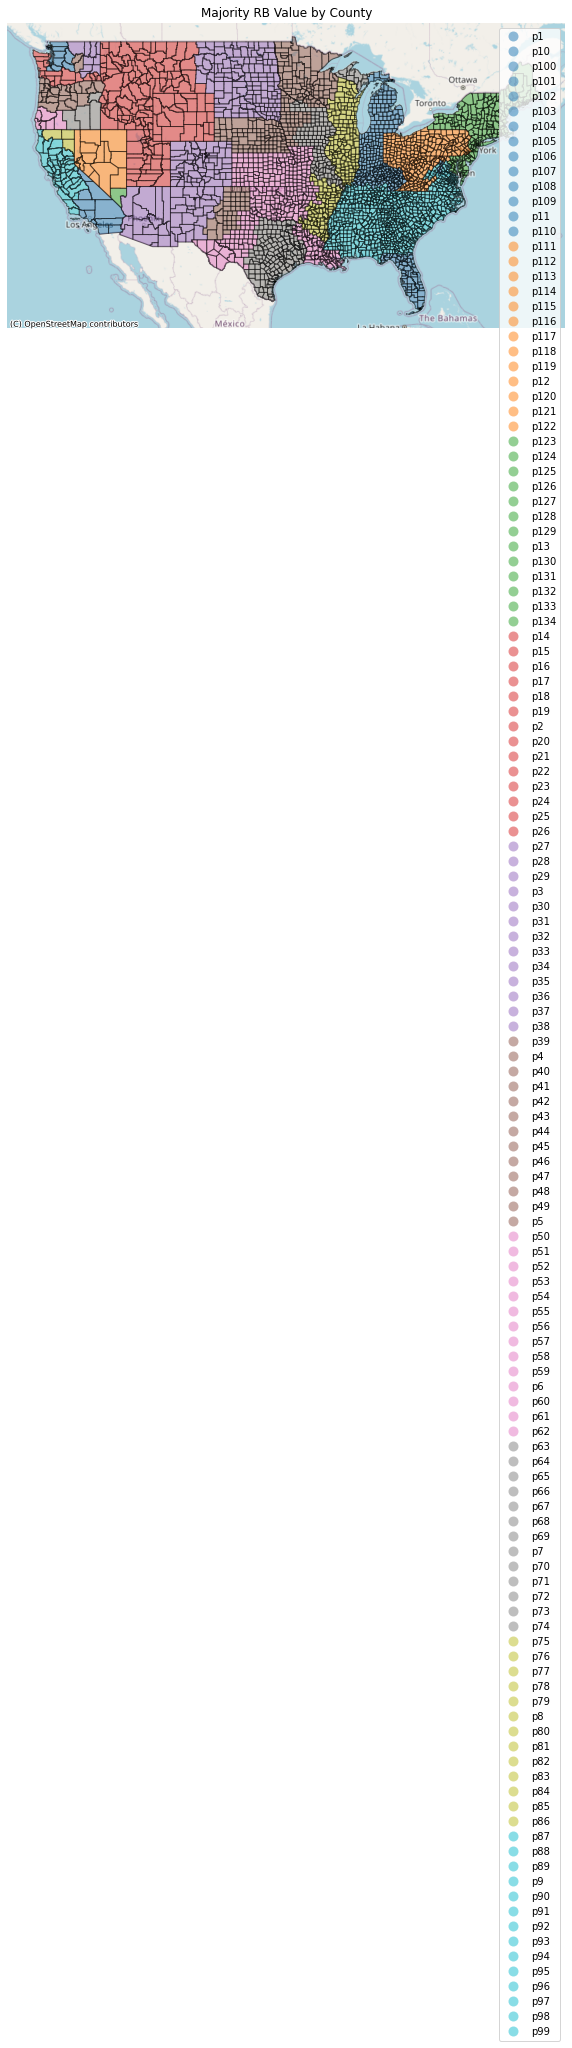

Mapping saved to '/Users/ansonkong/Downloads/Data for nyu work/output/majority_rb_value_by_county.csv'


In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import netCDF4 as nc
from shapely import wkt

# Load the new county shapefile and base file
new_county_shapefile_path = data_and_output_dir+'input/cb_2018_us_county_500k/cb_2018_us_county_500k.shp'
base_file_path = data_and_output_dir+'input/US_CAN_MEX_PCA_polygons.csv'
nc_file_path = data_and_output_dir+'input/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Prepare the data
new_counties = gpd.read_file(new_county_shapefile_path).to_crs(epsg=4326)
new_counties['FIPS'] = new_counties['GEOID'].astype(str).str.zfill(5)
base_df = pd.read_csv(base_file_path)
base_df['geometry'] = base_df['WKT'].apply(wkt.loads)
base_gdf = gpd.GeoDataFrame(base_df, geometry='geometry', crs='EPSG:4326')

# Load and process NetCDF data
ds = nc.Dataset(nc_file_path, 'r')
# Extract data points from NetCDF
time_step = 0  # First time step
lats = ds.variables['XLAT'][time_step, :, :]
lons = ds.variables['XLONG'][time_step, :, :]
gdf_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(np.ravel(lats), np.ravel(lons))], crs='EPSG:4326')

# Spatial join with base_gdf to get 'rb' values
gdf_points_with_rb = gpd.sjoin(gdf_points, base_gdf[['geometry', 'rb']], how='inner', predicate='intersects')
gdf_points_with_rb = gdf_points_with_rb.drop(columns=['index_left', 'index_right'], errors='ignore')

# Spatial join with new_counties to associate points with counties
gdf_points_with_county = gpd.sjoin(gdf_points_with_rb, new_counties[['geometry', 'FIPS']], how='left', predicate='intersects')
gdf_points_with_county = gdf_points_with_county.drop(columns=['index_left', 'index_right'], errors='ignore')

# Determine the majority 'rb' value for each county
majority_rb_by_county = gdf_points_with_county.groupby('FIPS')['rb'].agg(lambda x: x.mode()[0] if not x.empty else 'No RB Value').reset_index()

# Merge this information back with the new counties GeoDataFrame
counties_with_majority_rb = new_counties.merge(majority_rb_by_county, on='FIPS', how='left')

# Convert to Web Mercator for plotting
counties_with_majority_rb = counties_with_majority_rb.to_crs(epsg=3857)
counties_with_majority_rb.loc[counties_with_majority_rb['FIPS'] == '36061', 'rb'] = 'p127'

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
counties_with_majority_rb.plot(ax=ax, column='rb', legend=True, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Majority RB Value by County')
ax.set_axis_off()
plt.show()

# Save the mapping to a CSV file
output_path = data_and_output_dir+'output/majority_rb_value_by_county.csv'
counties_with_majority_rb[['FIPS', 'rb']].to_csv(output_path, index=False)
print(f"Mapping saved to '{output_path}'")

# Cleanup
ds.close()



In [8]:
# Step 1: Load the population data
population_data_path = data_and_output_dir+'input/Electric_Retail_Service_Territories/ssp3_county_population.csv'
population_data = pd.read_csv(population_data_path)

# Ensure FIPS codes are strings for consistent merging
population_data['FIPS'] = population_data['FIPS'].astype(str).str.zfill(5)
counties_with_majority_rb['FIPS'] = counties_with_majority_rb['FIPS'].astype(str).str.zfill(5)

# Step 2: Merge with the majority control area data
merged_data = pd.merge(population_data, counties_with_majority_rb[['FIPS', 'rb']], on='FIPS', how='left')

# Step 3: Check for missing values
# Missing in merged_data
missing_in_merged = merged_data[merged_data['rb'].isnull()]
print(f"Number of missing Majority_CNTRL_AREA in merged data: {missing_in_merged.shape[0]}")

# Missing in population_data not present in counties_with_majority_cntrl_area
missing_in_population = population_data[~population_data['FIPS'].isin( counties_with_majority_rb['FIPS'])]
print(f"Number of FIPS in population data not present in control area data: {missing_in_population.shape[0]}")

# Missing in counties_with_majority_cntrl_area not present in population_data
missing_in_control_area_data =  counties_with_majority_rb[~ counties_with_majority_rb['FIPS'].isin(population_data['FIPS'])]
print(f"Number of FIPS in control area data not present in population data: {missing_in_control_area_data.shape[0]}")


Number of missing Majority_CNTRL_AREA in merged data: 29
Number of FIPS in population data not present in control area data: 0
Number of FIPS in control area data not present in population data: 125


In [9]:
# Step 1: Extract all unique 'rb' values from the original base file
unique_rb_original = set(base_df['rb'].unique())

# Step 2: Extract all 'rb' values that appear in the finished data
rb_in_finished_data = set(counties_with_majority_rb['rb'].dropna().unique())

# Step 3: Find 'rb' values in the original data but not in the finished data
rb_missing_in_finished = unique_rb_original - rb_in_finished_data

print("RB values in original data but missing in finished data:", rb_missing_in_finished)

# Optional: Count of missing 'rb' values
print("Number of missing RB values:", len(rb_missing_in_finished))


RB values in original data but missing in finished data: {'p188', 'p161', 'p187', 'p137', 'p140', 'p195', 'p146', 'p204', 'p163', 'p170', 'p186', 'p190', 'p166', 'p174', 'p196', 'p145', 'p202', 'p141', 'p189', 'p184', 'p201', 'p150', 'p191', 'p194', 'p167', 'p200', 'p178', 'p197', 'p149', 'p154', 'p185', 'p181', 'p153', 'p159', 'p182', 'p205', 'p180', 'p148', 'p171', 'p162', 'p143', 'p165', 'p160', 'p138', 'p164', 'p158', 'p179', 'p157', 'p142', 'p199', 'p177', 'p156', 'p198', 'p144', 'p176', 'p152', 'p173', 'p183', 'p147', 'p193', 'p169', 'p155', 'p203', 'p192', 'p151', 'p139', 'p172', 'p168', 'p175'}
Number of missing RB values: 69


Number of counties with blank rb values: 154
FIPS codes of counties with blank rb values: ['02016', '02130', '02180', '02282', '15007', '15001', '15009', '72054', '72113', '72115', '72141', '72147', '78010', '78020', '02090', '02158', '02240', '60010', '60020', '69085', '69100', '69110', '72023', '72031', '72037', '72039', '72053', '02050', '02195', '02100', '72097', '72151', '02170', '60050', '78030', '02290', '02070', '02110', '02150', '02220', '02261', '66010', '02020', '15003', '51720', '51740', '72061', '72035', '72041', '72011', '72013', '60030', '60040', '69120', '72047', '72045', '72089', '72093', '72007', '72005', '72021', '72025', '72033', '51685', '51540', '51570', '51610', '02060', '02068', '02188', '02230', '02275', '02013', '72059', '72017', '51790', '72065', '72019', '51830', '72111', '72127', '72143', '72099', '72131', '72133', '72149', '72101', '72105', '72135', '72087', '72153', '72057', '72079', '72081', '72103', '51510', '51013', '72137', '72121', '72001', '51580', 

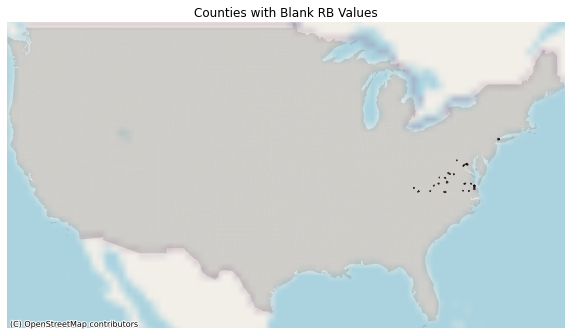

Number of mainland counties with blank rb values: 58
FIPS codes of mainland counties with blank rb values: ['02016', '02130', '02180', '02282', '02090', '02158', '02240', '02050', '02195', '02100', '02170', '02290', '02070', '02110', '02150', '02220', '02261', '02020', '51720', '51740', '51685', '51540', '51570', '51610', '02060', '02068', '02188', '02230', '02275', '02013', '51790', '51830', '51510', '51013', '51580', '51600', '51650', '02185', '51680', '51683', '51520', '51750', '02122', '51840', '51590', '51820', '02164', '36005', '51670', '51530', '51775', '02198', '51620', '51735', '51640', '02105', '51595', '51678']


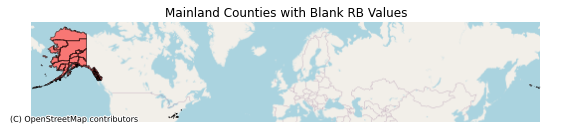

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx

# Filter counties with blank or 'No RB Value' rb values
blank_rb_counties = counties_with_majority_rb[pd.isnull(counties_with_majority_rb['rb']) ]

# Count the number of counties with blank rb values
num_blank_rb_counties = len(blank_rb_counties)
print(f"Number of counties with blank rb values: {num_blank_rb_counties}")

# List FIPS codes of counties with blank rb values
list_of_blank_rb_fips = blank_rb_counties['FIPS'].tolist()
print("FIPS codes of counties with blank rb values:", list_of_blank_rb_fips)

# Plotting counties with blank rb values
fig, ax = plt.subplots(figsize=(10, 10))
blank_rb_counties.plot(ax=ax, color='red', edgecolor='k', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Counties with Blank RB Values')
ax.set_xlim([-13884029, -7453304])  # These limits might need adjustment to better fit your specific shapefile
ax.set_ylim([2810491, 6338219])
ax.set_axis_off()

# Optionally, plot all counties for context and highlight those with blank rb in red
counties_with_majority_rb.plot(ax=ax, color='grey', alpha=0.3)  # Plot all counties in grey for context
blank_rb_counties.plot(ax=ax, color='red', edgecolor='k', alpha=0.5)  # Highlight counties with blank rb in red

plt.show()

# Convert FIPS codes to integers for comparison (ensure they are strings first to remove any leading zeros)
counties_with_majority_rb['FIPS'] = counties_with_majority_rb['FIPS'].astype(str).str.zfill(5)  # Ensure FIPS codes are 5 digits
counties_with_majority_rb['FIPS_int'] = counties_with_majority_rb['FIPS'].astype(int)

# Define FIPS code ranges for the mainland USA (this might need adjustments based on your specific requirements)
mainland_fips_ranges = [
    (1001, 2290),  # Alabama
    (4001, 4027),  # Arizona
    (5001, 5149),  # Arkansas
    (6001, 6115),  # California
    (8001, 8123),  # Colorado
    (9001, 9015),  # Connecticut
    (10001, 10005),  # Delaware
    (11001, 11001),  # District of Columbia
    (12001, 12133),  # Florida
    (13001, 13321),  # Georgia
    (16001, 16087),  # Idaho
    (17001, 17203),  # Illinois
    (18001, 18183),  # Indiana
    (19001, 19197),  # Iowa
    (20001, 20209),  # Kansas
    (21001, 21239),  # Kentucky
    (22001, 22127),  # Louisiana
    (23001, 23031),  # Maine
    (24001, 24510),  # Maryland
    (25001, 25027),  # Massachusetts
    (26001, 26165),  # Michigan
    (27001, 27173),  # Minnesota
    (28001, 28163),  # Mississippi
    (29001, 29510),  # Missouri
    (30001, 30111),  # Montana
    (31001, 31185),  # Nebraska
    (32001, 32110),  # Nevada
    (33001, 33019),  # New Hampshire
    (34001, 34041),  # New Jersey
    (35001, 35061),  # New Mexico
    (36001, 36123),  # New York
    (37001, 37199),  # North Carolina
    (38001, 38105),  # North Dakota
    (39001, 39175),  # Ohio
    (40001, 40153),  # Oklahoma
    (41001, 41071),  # Oregon
    (42001, 42133),  # Pennsylvania
    (44001, 44009),  # Rhode Island
    (45001, 45091),  # South Carolina
    (46001, 46137),  # South Dakota
    (47001, 47189),  # Tennessee
    (48001, 48493),  # Texas
    (49001, 49057),  # Utah
    (50001, 50027),  # Vermont
    (51001, 51840),  # Virginia
    (53001, 53077),  # Washington
    (54001, 54109),  # West Virginia
    (55001, 55141),  # Wisconsin
    (56001, 56045)  # Wyoming
]


# Function to check if a FIPS code is within the mainland USA ranges
def is_mainland_usa(fips):
    return any(lower <= fips <= upper for lower, upper in mainland_fips_ranges)

# Filter counties to include only those within the mainland USA
mainland_counties = counties_with_majority_rb[counties_with_majority_rb['FIPS_int'].apply(is_mainland_usa)]

# Filter counties with blank or 'No RB Value' rb values within the mainland USA
blank_rb_mainland_counties = mainland_counties[pd.isnull(mainland_counties['rb']) | (mainland_counties['rb'] == 'No RB Value')]

# Count the number of mainland counties with blank rb values
num_blank_rb_mainland_counties = len(blank_rb_mainland_counties)
print(f"Number of mainland counties with blank rb values: {num_blank_rb_mainland_counties}")

# List FIPS codes of mainland counties with blank rb values
list_of_blank_rb_mainland_fips = blank_rb_mainland_counties['FIPS'].tolist()
print("FIPS codes of mainland counties with blank rb values:", list_of_blank_rb_mainland_fips)

# Plotting mainland counties with blank rb values
fig, ax = plt.subplots(figsize=(10, 10))
blank_rb_mainland_counties.to_crs(epsg=3857).plot(ax=ax, color='red', edgecolor='k', alpha=0.5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('Mainland Counties with Blank RB Values')
ax.set_axis_off()

plt.show()

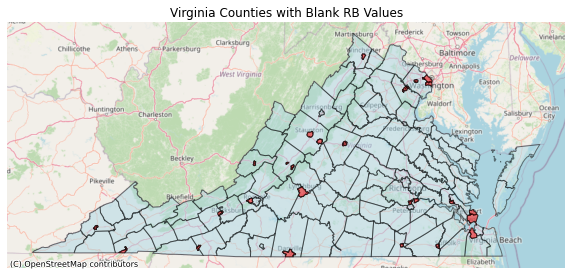

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Assuming mainland_counties is your GeoDataFrame and it's already filtered to mainland USA
# Filter for Virginia counties only (FIPS codes between 51001 and 51840)
virginia_counties = mainland_counties[(mainland_counties['FIPS_int'] >= 51001) & (mainland_counties['FIPS_int'] <= 51840)]

# Convert to Web Mercator for plotting with contextily
virginia_counties = virginia_counties.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
virginia_counties.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

# Optionally, highlight counties with blank rb values in red
blank_rb_virginia = blank_rb_mainland_counties[(blank_rb_mainland_counties['FIPS_int'] >= 51001) & (blank_rb_mainland_counties['FIPS_int'] <= 51840)]
blank_rb_virginia = blank_rb_virginia.to_crs(epsg=3857)
blank_rb_virginia.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Virginia Counties with Blank RB Values')
ax.set_axis_off()

plt.show()


In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer

# Assuming base_gdf and counties_gdf are already loaded
# Convert to Web Mercator for plotting with contextily basemap
base_gdf = base_gdf.to_crs(epsg=3857)
counties_gdf = counties_gdf.to_crs(epsg=3857)

# Define New York City's latitude and longitude
nyc_lat, nyc_lon = 40.7128, -74.0060

# Convert lat/lon to Web Mercator
transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
nyc_x, nyc_y = transformer.transform(nyc_lon, nyc_lat)

# Define a buffer around New York City for the zoom area (in meters)
buffer = 50000  # 10 km buffer for a closer view

# Calculate bounds for the zoom area
x_min, x_max = nyc_x - buffer, nyc_x + buffer
y_min, y_max = nyc_y - buffer, nyc_y + buffer

# Filter base_gdf to only include features within the zoom area
filtered_gdf = base_gdf.cx[x_min:x_max, y_min:y_max]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered 'rb' values
filtered_gdf.plot(ax=ax, column='rb', legend=True, markersize=50, alpha=0.5, cmap='viridis')

# Overlay county borders
counties_gdf.boundary.plot(ax=ax, color='black', linewidth=1)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Raw RB Values Visualization - New York City')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_axis_off()

plt.show()





NameError: name 'counties_gdf' is not defined

In [ ]:
#Trash can

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.interpolate import interp1d
import netCDF4 as nc
from shapely.geometry import Point
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
# Define paths
shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
county_shapefile_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp'
population_data_path = '/Users/ansonkong/Downloads/Electric_Retail_Service_Territories/ssp3_county_population.csv'
nc_file_path = '/Users/ansonkong/Downloads/tgw_wrf_rcp85hotter_hourly_2060-01-01_01_00_00.nc'

# Load data
print("Loading geographical data...")
# Load geographical data

ba_subregions = gpd.read_file(shapefile_path).to_crs(epsg=3857)
counties = gpd.read_file(county_shapefile_path).to_crs(epsg=3857) 
counties = counties.rename(columns={'ID': 'FIPS'})
# Check if 'CNTRL_AREA' needs adjustment (debugging)
#print("Control Areas:", ba_subregions['CNTRL_AREA'].unique())
print(f"Loaded {len(ba_subregions)} subregions and {len(counties)} counties.")

print("Loading and preparing population data...")
# Load and prepare population data
population_data = pd.read_csv(population_data_path)
print(f"Loaded population data for {len(population_data)} records.")
# Interpolation for population data
print("Interpolating population data...")
# Ensure FIPS codes are properly formatted (debugging)
#print("Population data FIPS unique values:", population_data['FIPS'].unique()[:5])
# Define years for interpolation
years = np.arange(2020, 2101, 10)  # Known population data years
interp_years = np.arange(2020, 2101)  # Target years for interpolation

# Perform interpolation for each FIPS code
for index, row in population_data.iterrows():
    fips = row['FIPS']
    pop_values = row[years.astype(str)].values
    interpolator = interp1d(years, pop_values, kind='linear', fill_value="extrapolate")
    interpolated_values = interpolator(interp_years)
    population_data.loc[index, interp_years.astype(str)] = interpolated_values

print("Population data interpolation complete.")

print("Opening NetCDF file...")
# Open NetCDF file
ds = nc.Dataset(nc_file_path, 'r')

# Accessing and cleaning the 'Times' variable
print("Processing time variable...")
times_array = ds.variables['Times'][:]  # Assuming 'Times' is the time variable
times_str_list = [b''.join(times_array[t]).decode('ascii') for t in range(times_array.shape[0])]
times = pd.to_datetime(times_str_list, format='%Y-%m-%d_%H:%M:%S')

print(f"Found {len(times)} time steps.")


year_of_interest = str(times[0].year) 
# Prepare NetCDF data points
# Preparing NetCDF data points
print("Preparing NetCDF data points...")
lats = ds.variables['XLAT'][0, :, :]
lons = ds.variables['XLONG'][0, :, :]
print(f"Latitude shape: {lats.shape}, Longitude shape: {lons.shape}")


variables = ['T2', 'Q2', 'SWDOWN', 'GLW', 'WSPD']  # Assuming these are the variables you're interested in
print(ds.variables['XLAT'].shape)
print(ds.variables['XLONG'].shape)
for var in variables:
    print(var, ds.variables[var].shape)
data_points=[]
# Create a DataFrame for NetCDF data points with environmental variables
# Assuming 'variables' contains the names of the environmental variables you're interested in
# Extract data for each variable and create a list of dictionaries for each point
# Corrected loop to access data for a single time step
time_step = 0  # Selecting the first time step

# Select the time slice for latitude and longitude arrays
lat_slice = lats
lon_slice = lons
total_time_steps = len(times_array)
total_lat_points = lat_slice.shape[0]
total_lon_points = lon_slice.shape[1]
total_iterations = total_time_steps * total_lat_points * total_lon_points

#print(f"Starting processing at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total iterations: {total_iterations}")

# Initialize a counter to track progress
iteration_counter = 0
# Prepare data_points list for GeoDataFrame
data_points = []


for time_step, time_value in enumerate(times[:1]):
#for time_step, time_value in enumerate(times):
#Limit number of time run
    for i in range(total_lat_points):
        for j in range(total_lon_points):
            lat = ds.variables['XLAT'][time_step, i, j]
            lon = ds.variables['XLONG'][time_step, i, j]
            point_data = {
                'Time': time_value,
                'Latitude': lat,
                'Longitude': lon,
                'geometry': Point(lon, lat)
            }
            for var in variables:
                point_data[var] = ds.variables[var][time_step, i, j]
            data_points.append(point_data)
            
            # Update the iteration counter
            iteration_counter += 1
            
            # Print progress for every 1% completed
            if iteration_counter % (total_iterations // 100) == 0:
                percent_done = (iteration_counter / total_iterations) * 100
                print(f"Progress: {percent_done:.2f}% completed.")

# Convert to GeoDataFrame

gdf_points = gpd.GeoDataFrame(data_points, crs='EPSG:3857')
print("Processing completed.")
# Assuming gdf_points, counties_with_majority_area, and ba_subregions are ready and in EPSG:3857

fig, ax = plt.subplots(figsize=(15, 15))

# Plot points from NetCDF data
gdf_points.plot(ax=ax, color='blue', column='CNTRL_AREA',markersize=5, alpha=0.5, label='NetCDF Data Points')



# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()



fig, ax = plt.subplots(figsize=(15, 15))



# Plot counties with majority control area
# Note: This assumes counties_with_majority_area is a GeoDataFrame with a 'CNTRL_AREA' column used for coloring
print(counties.columns)
counties.plot(ax=ax, column='FIPS', alpha=0.5, edgecolor='k', legend=True, label='Counties Majority Control Area')


# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()



fig, ax = plt.subplots(figsize=(15, 15))


# Overlay the boundaries of the subregions
ba_subregions.boundary.plot(ax=ax, color='red', linewidth=1, alpha=0.7, label='Subregions Boundary')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and adjust plot
ax.set_title('Overlay of NetCDF Data Points, Counties, and Subregions', fontsize=20)

# Remove axis for a cleaner look
ax.set_axis_off()

# Add legend
ax.legend()

plt.show()

In [115]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import geopandas as gpd
from datetime import datetime
# Load control area mapping
control_area_path = '/Users/ansonkong/Downloads/county_control_area_mapping_no_state_fips.csv'
control_area_df = pd.read_csv(control_area_path)

# Load meteorology data
meteorology_path = '/Users/ansonkong/Downloads/rcp85hotter/2060/2060_01_01_02_UTC_County_Mean_Meteorology.csv'
meteorology_df = pd.read_csv(meteorology_path)
# Calculate wind speed
meteorology_df['WSPD'] = np.sqrt(meteorology_df['U10']**2 + meteorology_df['V10']**2)
# Add 'year' and 'UTC time' to meteorology data
file_name = os.path.basename(meteorology_path)  # Gets '2060_01_01_01_UTC_County_Mean_Meteorology.csv'
year_utc_time = file_name.split('_UTC')[0]  # Gets '2060_01_01_01'
year = year_utc_time.split('_')[0]  # Gets '2060'
utc_time = '_'.join(year_utc_time.split('_')[:4])  # Gets '2060_01_01_01'
# Parse the original string to a datetime object
dt = datetime.strptime(utc_time, '%Y_%m_%d_%H')

# Format the datetime object to the desired format
utc_time= dt.strftime('%-m/%-d/%Y %-I:%M:%S %p')
meteorology_df['year'] = year
meteorology_df['Time_UTC'] = utc_time
# Merge on FIPS
merged_df = pd.merge(control_area_df, meteorology_df, on='FIPS', how='inner')
# Assuming population_data is loaded and prepared similarly
# Perform interpolation (example shown for clarity; adjust as needed)
years = np.arange(2020, 2101, 10)
interp_years = np.arange(2020, 2101)

for index, row in merged_df.iterrows():
    pop_values = row[years.astype(str)].values
    interpolator = interp1d(years, pop_values, kind='linear', fill_value="extrapolate")
    interpolated_values = interpolator(interp_years)
    population_data.loc[index, interp_years.astype(str)] = interpolated_values
# Example of grouping and applying weighted average
def weighted_average(group, columns):
    year_col = str(group['year'].iloc[0])  # Assuming year is constant within each group
    weights = group[year_col]  # This assumes a direct match, which might need adjustment
    return {col: np.average(group[col], weights=weights) for col in columns}

# Assuming 'columns' is a list of meteorology columns to aggregate
columns = meteorology_df.columns.difference(['FIPS', 'year', 'Time_UTC'])

# Apply the weighted average within each group
grouped = merged_df.groupby([ 'Majority_CNTRL_AREA', 'year', 'Time_UTC']).apply(lambda x: weighted_average(x, columns)).reset_index()

# Convert the result into a DataFrame if necessary
# This part needs custom handling based on the structure of 'grouped'
# Assuming 'grouped' is your DataFrame with the aggregated results stored in column '0'
# Expand the dictionaries in column '0' into separate columns
expanded_grouped = grouped[0].apply(pd.Series)

# Now, 'expanded_grouped' contains the columns expanded from the dictionaries
# You might want to join this back with the 'grouped' DataFrame to keep any other columns
grouped_expanded = grouped.drop(columns=[0]).join(expanded_grouped)




# Now 'meteorology_df' contains a new column 'wind_speed' with the calculated wind speed

# 'grouped_expanded' now contains the original grouping columns and the expanded meteorology columns
grouped_expanded


/var/folders/8v/68yqll_54lzgb57b5q8_fbrc0000gn/T/ipykernel_47659/2685088704.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = merged_df.groupby([ 'Majority_CNTRL_AREA', 'year', 'Time_UTC']).apply(lambda x: weighted_average(x, columns)).reset_index()


,Majority_CNTRL_AREA,year,Time_UTC,GLW,Q2,SWDOWN,T2,U10,V10,WSPD
0,"ASSOCIATED ELECTRIC COOPERATIVE, INC.",2060,1/1/2060 2:00:00 AM,257.059526,0.004201,0.0,277.994365,1.416583,-1.978802,2.510004
1,AVISTA CORPORATION,2060,1/1/2060 2:00:00 AM,269.063361,0.004811,0.0,276.648390,-0.950824,1.115138,1.681530
2,BONNEVILLE POWER ADMINISTRATION,2060,1/1/2060 2:00:00 AM,325.199754,0.005937,0.0,279.975564,-1.520324,2.369487,3.605265
3,CITY OF HOMESTEAD,2060,1/1/2060 2:00:00 AM,372.530000,0.012990,0.0,292.950000,1.780000,-2.250000,2.868955
4,DUKE ENERGY CAROLINAS,2060,1/1/2060 2:00:00 AM,314.702666,0.004823,0.0,281.846401,-0.062493,-1.634027,1.718046
5,DUKE ENERGY FLORIDA INC,2060,1/1/2060 2:00:00 AM,316.510965,0.007770,0.0,286.835987,2.938773,-1.075178,3.355247
6,DUKE ENERGY PROGRESS EAST,2060,1/1/2060 2:00:00 AM,329.527006,0.006139,0.0,282.956636,-0.969444,-2.592548,2.909292
7,EL PASO ELECTRIC COMPANY,2060,1/1/2060 2:00:00 AM,264.582481,0.003052,0.0,284.858558,0.017796,0.453895,0.508574
8,"ELECTRIC ENERGY, INC.",2060,1/1/2060 2:00:00 AM,255.420000,0.004680,0.0,278.150000,2.020000,-0.470000,2.073958
9,"ELECTRIC RELIABILITY COUNCIL OF TEXAS, INC.",2060,1/1/2060 2:00:00 AM,269.123092,0.004510,0.0,281.709297,0.628441,-1.631920,2.161360


In [108]:
# Assuming 'grouped' is your DataFrame with the aggregated results stored in column '0'
# Expand the dictionaries in column '0' into separate columns
expanded_grouped = grouped[0].apply(pd.Series)

# Now, 'expanded_grouped' contains the columns expanded from the dictionaries
# You might want to join this back with the 'grouped' DataFrame to keep any other columns
grouped_expanded = grouped.drop(columns=[0]).join(expanded_grouped)

# 'grouped_expanded' now contains the original grouping columns and the expanded meteorology columns
grouped_expanded

,Majority_CNTRL_AREA,year,UTC time,GLW,Q2,SWDOWN,T2,U10,V10
0,"ASSOCIATED ELECTRIC COOPERATIVE, INC.",2060,2060_01_01_01,262.117512,0.004241,0.0,278.795853,1.524250,-2.220998
1,AVISTA CORPORATION,2060,2060_01_01_01,278.524420,0.004990,0.0,277.289779,-0.605450,1.359026
2,BONNEVILLE POWER ADMINISTRATION,2060,2060_01_01_01,324.665217,0.005952,0.0,280.143444,-1.598409,2.685304
3,CITY OF HOMESTEAD,2060,2060_01_01_01,379.050000,0.013370,0.0,294.040000,1.970000,-1.940000
4,DUKE ENERGY CAROLINAS,2060,2060_01_01_01,319.658045,0.004838,0.0,282.326022,-0.275065,-1.625150
5,DUKE ENERGY FLORIDA INC,2060,2060_01_01_01,318.707260,0.007861,0.0,287.689066,3.145057,-1.165224
6,DUKE ENERGY PROGRESS EAST,2060,2060_01_01_01,329.502565,0.006138,0.0,283.289500,-0.988248,-2.580932
7,EL PASO ELECTRIC COMPANY,2060,2060_01_01_01,266.359178,0.003037,0.0,285.732476,0.861384,-0.488308
8,"ELECTRIC ENERGY, INC.",2060,2060_01_01_01,293.390000,0.004900,0.0,279.170000,2.100000,0.040000
9,"ELECTRIC RELIABILITY COUNCIL OF TEXAS, INC.",2060,2060_01_01_01,272.410555,0.004556,0.0,282.668083,0.759824,-1.896222
